Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import rdflib
from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph
from rdflib.namespace import DC, FOAF

import networkx as nx
import networkx.algorithms.community as nx_comm

from owlready2 import *
from owlready2 import get_ontology

from sklearn.model_selection import train_test_split

random.seed(10)

Loading the original data

In [2]:
data = pd.read_excel('/Users/ninaliem/Downloads/opioids_data_original.xlsx')

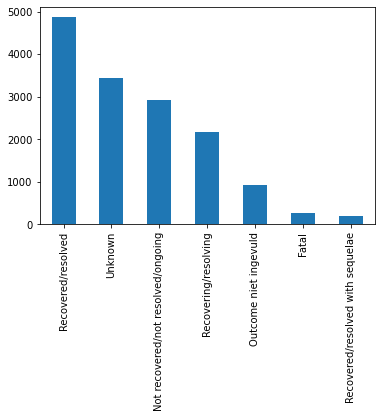

In [3]:
data.Outcome.value_counts().plot(kind='bar');

In [4]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered/resolved                    32.909681
Unknown                               23.201731
Not recovered/not resolved/ongoing    19.808004
Recovering/resolving                  14.663332
Outcome niet ingevuld                  6.280422
Fatal                                  1.852353
Recovered/resolved with sequelae       1.284478
Name: Outcome, dtype: float64

Changing the 'Outcome' column values and removing the 'Unknown' values

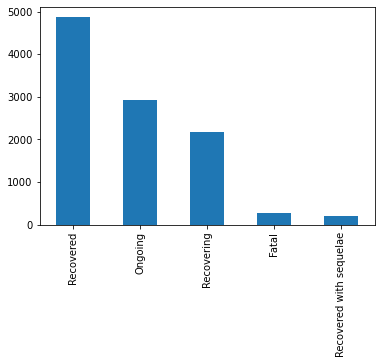

In [5]:
data['Outcome'] = data['Outcome'].replace(['Outcome niet ingevuld', 'Recovered/resolved', 'Not recovered/not resolved/ongoing', 'Recovered/resolved with sequelae', 'Recovering/resolving'], ['Unknown', 'Recovered', 'Ongoing', 'Recovered with sequelae', 'Recovering'])
data = data[data['Outcome'] != 'Unknown']
data.Outcome.value_counts().plot(kind='bar');

In [6]:
data['Outcome'].value_counts(normalize=True) * 100

Recovered                  46.668584
Ongoing                    28.089349
Recovering                 20.793788
Fatal                       2.626786
Recovered with sequelae     1.821494
Name: Outcome, dtype: float64

Train-test split (80-20)

In [7]:
train, test = train_test_split(data, test_size=0.2)

Further cleaning of the train set

In [8]:
train.columns

Index(['WorldwideUniqueCaseIdentification', 'Status', 'Category', 'BodyWeight',
       'Height', 'date_received', 'sex', 'age_year', 'Outcome',
       'OutcomeCodeSystemVersion', 'OutcomeText', 'reaction_impact', 'ATCText',
       'ATCode', 'GenericDrugName', 'ID', 'CultureID', 'LLTCode', 'LLTName',
       'PTCode', 'PTName', 'HLTCode', 'HLTName', 'HLTGCode', 'HLTGName',
       'SOCCode', 'SOCName', 'SOCAbbreviation', 'IsCurrent', 'IsDefaultSOC',
       'Primary Source Description', 'summary', 'narrative'],
      dtype='object')

Analyze the min/mean/max values per column to detect which columns potentially contain outliers

In [9]:
train.describe()

,Status,Category,BodyWeight,Height,age_year,OutcomeCodeSystemVersion,reaction_impact,ID,LLTCode,PTCode,HLTCode,HLTGCode,SOCCode,IsCurrent,IsDefaultSOC
count,8344.0,0.0,5325.000000,5138.000000,7266.000000,3071.0,2002.000000,8344.000000,8.344000e+03,8.344000e+03,8.344000e+03,8.344000e+03,8.344000e+03,8344.000000,8344.000000
mean,40.0,NaN,74.944826,167.044492,53.878847,2.0,3.718781,250726.102709,1.002768e+07,1.002794e+07,1.002714e+07,1.002899e+07,1.002741e+07,0.999041,0.671021
std,0.0,NaN,22.265276,27.339176,18.592670,0.0,1.122812,33542.926354,1.733409e+04,1.746881e+04,2.033721e+04,2.118144e+04,1.100375e+04,0.030951,0.469870
min,40.0,NaN,0.000000,0.000000,0.000000,2.0,1.000000,202593.000000,1.000006e+07,1.000006e+07,1.000003e+07,1.000021e+07,1.000533e+07,0.000000,0.000000
25%,40.0,NaN,64.000000,165.000000,41.000000,2.0,3.000000,222909.000000,1.001358e+07,1.001358e+07,1.001233e+07,1.001498e+07,1.001806e+07,1.000000,0.000000
50%,40.0,NaN,75.000000,170.000000,55.000000,2.0,4.000000,245350.000000,1.002254e+07,1.002252e+07,1.002253e+07,1.001928e+07,1.002840e+07,1.000000,1.000000
75%,40.0,NaN,84.000000,178.000000,68.000000,2.0,5.000000,267705.000000,1.004135e+07,1.004135e+07,1.003464e+07,1.003991e+07,1.003718e+07,1.000000,1.000000
max,40.0,NaN,500.000000,208.000000,100.000000,2.0,5.000000,336402.000000,1.008542e+07,1.008564e+07,1.008451e+07,1.008221e+07,1.007754e+07,1.000000,1.000000


- 'Bodyweight' has a max value of 500kg, and a min of 0. These values are potential outliers.
- Additionally, 'Height' has a min of 0, which is likely an outlier. 
- 'Status' only contains the value '40', and can therefore be discarded.
- 'Category' only contains NaN values, and therefore can be discarded.
- The min and max of 'age_year' may require some further analysis.
- 'OutcomeCodeSystemVersion' only contains the value '2.0', and therefore can be discarded.
- 'ID' is an ID and should therefore not be used for prediction.
- Most of the codes are not relevant but we'll get back to this later

Let's remove some columns before we continue:

In [10]:
train = train.drop(columns=['Status', 'Category', 'OutcomeCodeSystemVersion', 'OutcomeText', 'CultureID', 'WorldwideUniqueCaseIdentification', 'date_received', 'summary', 'narrative', 'IsCurrent', 'IsDefaultSOC'])

Bodyweight

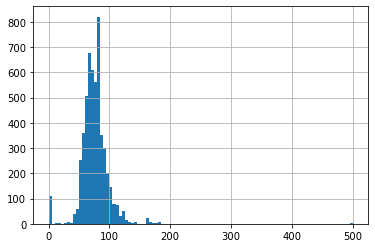

In [11]:
train['BodyWeight'].hist(bins=100); # Fairly normally distributed 

In [12]:
print(f'There are {(data.BodyWeight == 500).sum()} patients with a weight of 500kg.')
print(f'Which is equal to the amount of patients above 200kg: {(data.BodyWeight > 200).sum()}')

There are 3 patients with a weight of 500kg.
Which is equal to the amount of patients above 200kg: 3


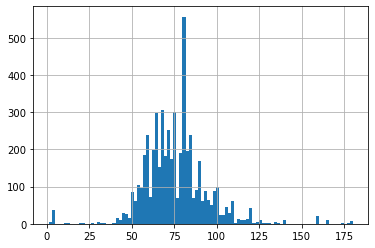

In [13]:
train[(train.BodyWeight != 0) & (train.BodyWeight != 500)]['BodyWeight'].hist(bins=100); 
# Would be more normally distributed if values of 0 and > 500 are removed
# There is quite a big spread, but this is ok for weight groups + may potentially change after removal of other outliers

Height

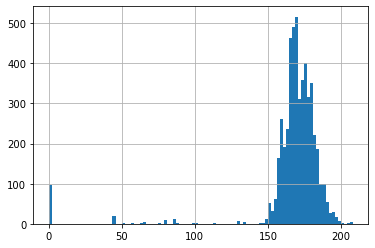

In [14]:
train['Height'].hist(bins=100); 

In [15]:
print(f'There are {(data.Height < 150).sum()} patients that are shorter than 1.50m.')
print(f'There are {(data.Height > 200).sum()} patients that are taller than 2.00m.')

There are 245 patients that are shorter than 1.50m.
There are 5 patients that are taller than 2.00m.


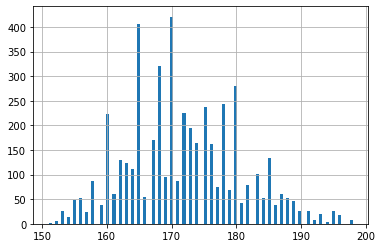

In [16]:
train[(train.Height > 150) & (train.Height < 200)]['Height'].hist(bins=100); 
# Would be more normally distributed if values of 0 and > 500 are removed


Age

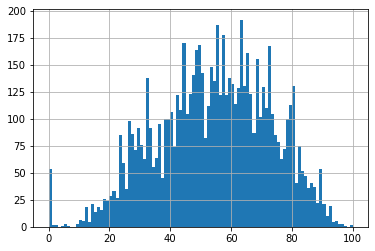

In [17]:
train['age_year'].hist(bins=100);

In [18]:
print(f'There are {(data.age_year < 18).sum()} patients that are younger than 18.')
print(f'There are {(data.age_year > 90).sum()} patients that are older than 95.')

There are 211 patients that are younger than 18.
There are 66 patients that are older than 95.


Filtering out the patients below 18:

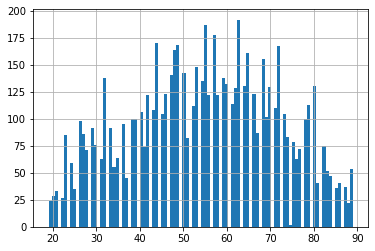

In [19]:
train[(train.age_year > 18) & (train.age_year < 90)]['age_year'].hist(bins=100); 

Let's actually implement the removal of these outliers:

In [20]:
train = train[(train.BodyWeight != 0) & (train.BodyWeight != 500)] # Removal of instances with bodyweight == 0 or 500
train = train[(train.Height > 150) & (train.Height < 200)] # Removal of instances shorter than 150 and taller than 200
train = train[(train.age_year > 18) & (train.age_year < 90)] # Removal of instances younger than 18 and older than 90

Analysis of the 'Outcome' column per sex

In [21]:
print(f'There are {(train.sex == "female").sum()} females.')
print(f'There are {(train.sex == "male").sum()} males.')
pd.crosstab(index=train['Outcome'], columns=train['sex'])


There are 2985 females.
There are 1304 males.


sex,female,male
Outcome,,
Fatal,28,7
Ongoing,865,440
Recovered,1271,522
Recovered with sequelae,63,33
Recovering,758,302


Analysis of the 'Outcome' column per opioid.

In [22]:
pd.crosstab(index=train['Outcome'], columns=train['ATCText'])

ATCText,BUPRENORFINE,CODEINE MET PARACETAMOL,DEXTROPROPOXYFEEN,FENTANYL,HYDROMORFON,MORFINE,"MORFINE, COMBINATIEPREPARATEN",OXYCODON,OXYCODON MET NALOXON,PETHIDINE,PIRITRAMIDE,TAPENTADOL,TRAMADOL,TRAMADOL MET PARACETAMOL
Outcome,,,,,,,,,,,,,,
Fatal,0,0,0,10,0,12,0,6,0,0,1,0,6,0
Ongoing,73,8,0,125,0,108,0,403,3,4,1,18,453,109
Recovered,172,23,2,77,1,190,2,447,0,5,27,31,697,119
Recovered with sequelae,14,0,1,9,0,4,0,35,0,0,0,0,25,8
Recovering,101,31,1,70,1,36,0,292,3,1,8,6,384,126


There are some variations of the opioids. For simplicty's sake, let's group them together. 

tramadol met paracetamol; N02AJ13 --> N02AX02
oxy met nalo; N02AA55 --> N02AA05
morf combi; N02AA51 --> N02AA01

In [23]:
train['ATCText'].replace(['TRAMADOL MET PARACETAMOL', 'OXYCODON MET NALOXON', 'MORFINE, COMBINATIEPREPARATEN'], ['TRAMADOL', 'OXYCODON', 'MORFINE'], inplace=True)

train['ATCode'].replace(['N02AJ13', 'N02AA51'], ['N02AX02', 'N02AA01'], inplace=True)

In [24]:
pd.crosstab(index=train['Outcome'], columns=train['ATCText'])

ATCText,BUPRENORFINE,CODEINE MET PARACETAMOL,DEXTROPROPOXYFEEN,FENTANYL,HYDROMORFON,MORFINE,OXYCODON,PETHIDINE,PIRITRAMIDE,TAPENTADOL,TRAMADOL
Outcome,,,,,,,,,,,
Fatal,0,0,0,10,0,12,6,0,1,0,6
Ongoing,73,8,0,125,0,108,406,4,1,18,562
Recovered,172,23,2,77,1,192,447,5,27,31,816
Recovered with sequelae,14,0,1,9,0,4,35,0,0,0,33
Recovering,101,31,1,70,1,36,295,1,8,6,510


Let's further analyse the different outcomes:

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_17920/1377794518.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[train['Outcome'] == 'Fatal'].hist(bins=20, ax=ax);


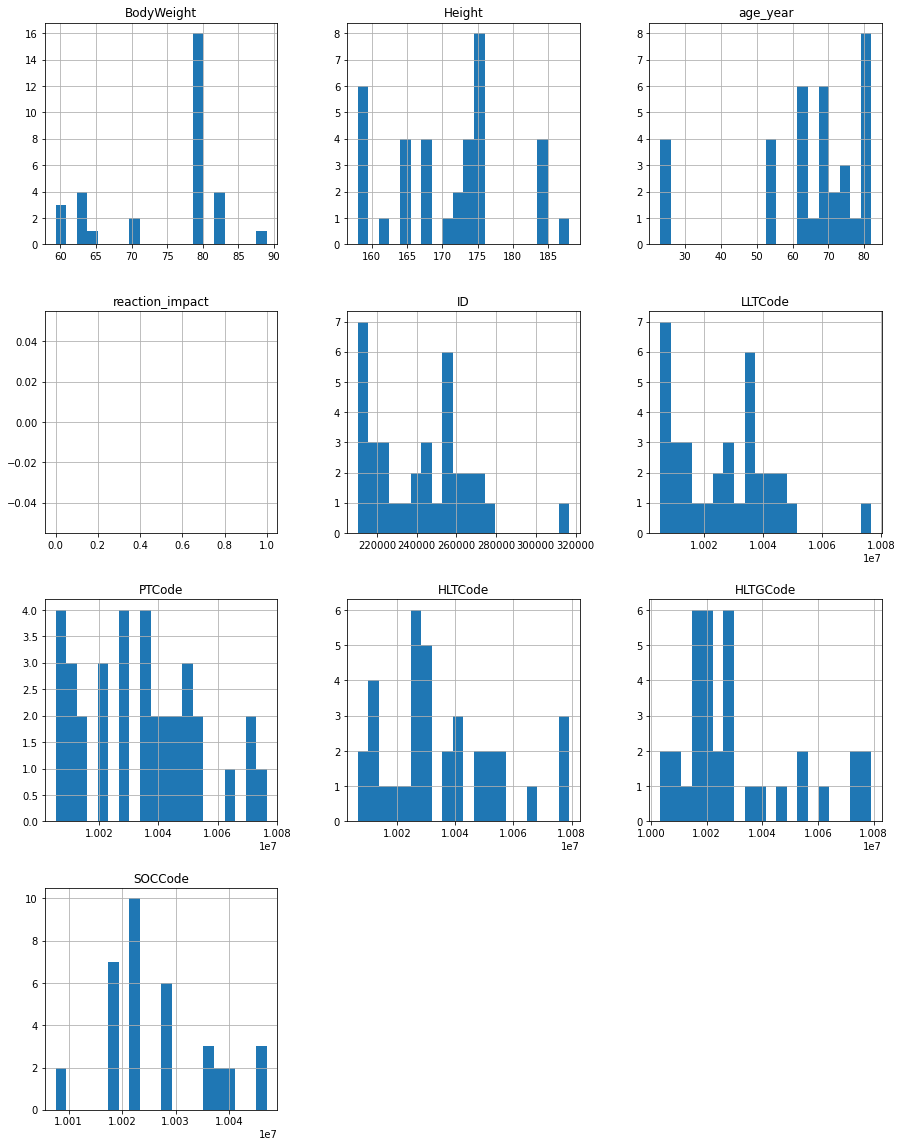

In [25]:
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
train[train['Outcome'] == 'Fatal'].hist(bins=20, ax=ax);

Fatalities have no reaction impact, which makes sense. Additionally, fatalities mostly concern older (60+) individuals. 

/var/folders/05/qjd8g9k56h39h870tqqlgw3m0000gn/T/ipykernel_17920/2999783698.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[train['Outcome'] == 'Recovered with sequelae'].hist(bins=20, ax=ax);


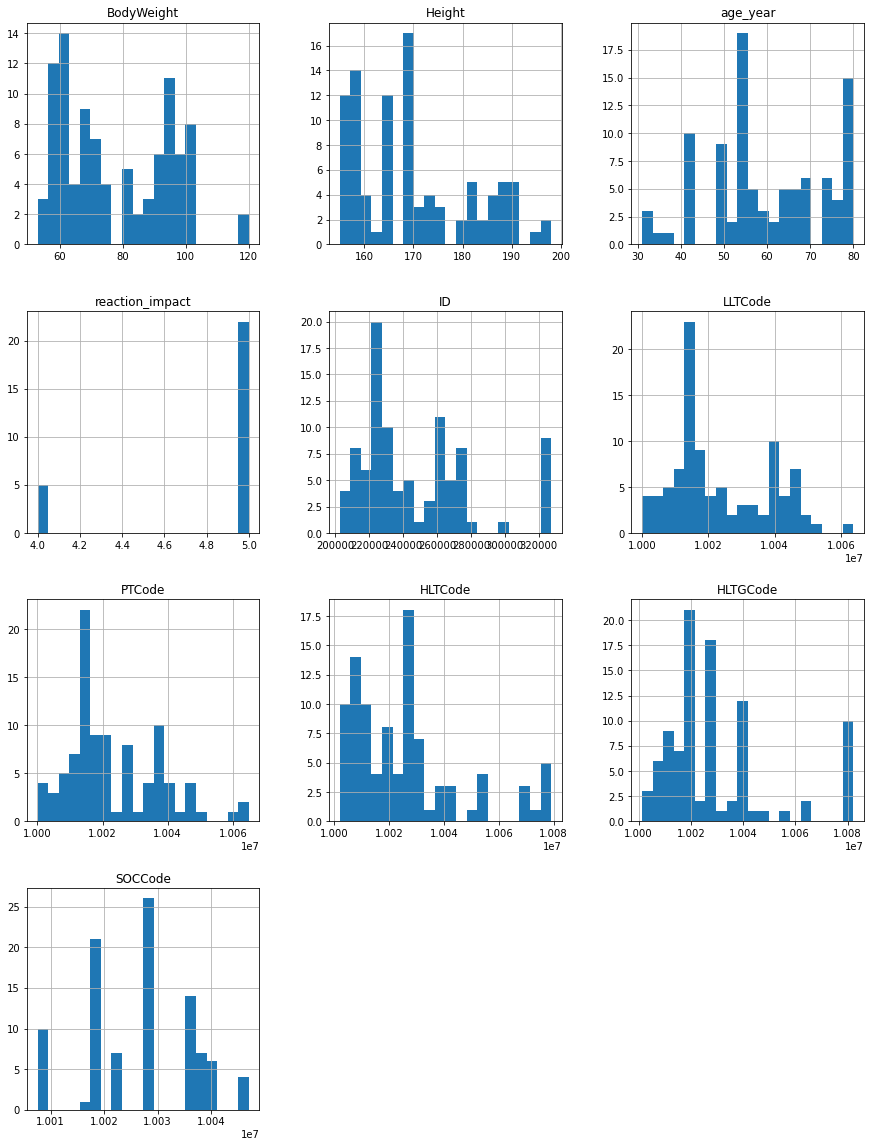

In [26]:
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
train[train['Outcome'] == 'Recovered with sequelae'].hist(bins=20, ax=ax);

Analysis of the missing values per column:

In [27]:
train.isna().sum()

BodyWeight                      31
Height                           0
sex                              0
age_year                         0
Outcome                          0
reaction_impact               2755
ATCText                          0
ATCode                           0
GenericDrugName                  0
ID                               0
LLTCode                          0
LLTName                          0
PTCode                           0
PTName                           0
HLTCode                          0
HLTName                          0
HLTGCode                         0
HLTGName                         0
SOCCode                          0
SOCName                          0
SOCAbbreviation                  0
Primary Source Description      60
dtype: int64

Only three columns have missing values: the 'BodyWeight' column, the 'reaction_impact' column and the 'Primary Source Description' column. We can impute the missing values for the first two columns by taking a relevant average. The last column requires a bit more processing to source useful information.

The 'reaction_impact' column presumably measures the impact the medicine has had on the patient. As shown before, there is no reaction_impact for fatalities. 
We can impute the missing values by taking the average of a patient with similar features. 

To make this easier, we'll first create a column to bin the ages. We'll also create a BMI column and a weight group column.

In [28]:
train['age_group'] = pd.cut(x=train['age_year'], bins=[18, 24, 44, 64, 90])

train['BMI'] = train['BodyWeight'] / (train['Height']/100)**2

train['weight_group'] = pd.cut(x=train['BMI'], bins=[0, 18.5, 25, 30, 50], labels=['underweight', 'normal', 'overweight', 'obese'])

Filling the missing reaction_impact values with averages based on patient characteristics/medicine taken/outcome:

In [29]:
train['reaction_impact'] = train['reaction_impact'].fillna(train.groupby(['sex', 'age_group', 'weight_group', 'Outcome', 'ATCText'])['reaction_impact'].transform('mean'))
train['reaction_impact'] = train['reaction_impact'].fillna(train.groupby(['sex', 'Outcome', 'ATCText'])['reaction_impact'].transform('mean'))
train['reaction_impact'] = train['reaction_impact'].fillna(train.groupby(['Outcome'])['reaction_impact'].transform('mean'))

Drop remaining rows without a reaction_impact (30 in total)

In [30]:
train = train[train['reaction_impact'].notna()]

Drop rows that do not have a weight_group (31 in total)

In [31]:
train = train[train['weight_group'].notna()]

In [32]:
train.isna().sum()

BodyWeight                     0
Height                         0
sex                            0
age_year                       0
Outcome                        0
reaction_impact                0
ATCText                        0
ATCode                         0
GenericDrugName                0
ID                             0
LLTCode                        0
LLTName                        0
PTCode                         0
PTName                         0
HLTCode                        0
HLTName                        0
HLTGCode                       0
HLTGName                       0
SOCCode                        0
SOCName                        0
SOCAbbreviation                0
Primary Source Description    60
age_group                      0
BMI                            0
weight_group                   0
dtype: int64

We'll drop the Primary Source Description column for now.

In [33]:
train = train.drop(columns=['Primary Source Description']).reset_index(drop=True)

Add dosage and dosage form columns:

In [34]:
gdn = list(data['GenericDrugName'].str.split(' ', expand=True).stack().unique())
type = ['CAPSULE', 'NEUSSPRAY', 'TABLET', 'PLEISTER', 'INJVLST', 'ZETPIL', 'DRANK', 'SPRAY', 'ZUIGTABLET', 'BRUISTABLET', 'INJ/INFOPL', 'INFVLST', 'DRUPPELS', 'SMELTTABLET', 'INJECTIE/INFUUS', 'DISPERTABLET', 'TAB', 'INJECTIEPOEDER']
dosage = []

def has_numbers(inputString):
    return bool(re.search(r'\d', inputString))

for i in gdn:
    if has_numbers(i):
        dosage.append(i)

train['dosage_form'] = train['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in type]))
train['dosage'] = train['GenericDrugName'].apply(lambda x : ''.join([k for k in str(x).split() if k in dosage]))
#heatmap_data['dosage'] = heatmap_data.dosage.str.extract('(\d+)').astype('int64')
#heatmap_data['dosage_form'].replace(['CAPSULE', 'INFVLST', 'TABLET', 'PLEISTER', 'INJVLST', 'DRANK',
#       'ZETPIL', 'BRUISTABLET', 'DRUPPELS', 'NEUSSPRAY'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], inplace=True)

In [35]:
train = train.drop(columns=['GenericDrugName'])

In [36]:
train

,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,ID,LLTCode,...,HLTGCode,HLTGName,SOCCode,SOCName,SOCAbbreviation,age_group,BMI,weight_group,dosage_form,dosage
0,73.0,179.0,female,55.0,Recovered,4.000000,BUPRENORFINE,N02AE01,257417.0,10036653.0,...,10029305.0,Neurological disorders NEC,10029205.0,Nervous system disorders,Nerv,"(44, 64]",22.783309,normal,PLEISTER,10UG/UUR
1,73.0,168.0,female,23.0,Recovered,3.000000,TRAMADOL,N02AX02,210136.0,10005143.0,...,10047075.0,Vascular haemorrhagic disorders,10047065.0,Vascular disorders,Vasc,"(18, 24]",25.864512,overweight,TABLET,"37,5/325MG"
2,65.0,170.0,female,67.0,Ongoing,4.000000,TRAMADOL,N02AX02,240617.0,10025482.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(64, 90]",22.491349,normal,CAPSULE,50MG
3,65.0,170.0,female,59.0,Recovered with sequelae,4.837321,TRAMADOL,N02AX02,273290.0,10047700.0,...,10018012.0,Gastrointestinal signs and symptoms,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",22.491349,normal,CAPSULE,50MG
4,95.0,180.0,female,29.0,Recovered,1.000000,TRAMADOL,N02AX02,214862.0,10008531.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(24, 44]",29.320988,overweight,CAPSULE,50MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,102.0,180.0,female,65.0,Recovered,4.000000,OXYCODON,N02AA05,272806.0,10047340.0,...,10022396.0,Inner ear and VIIIth cranial nerve disorders,10013993.0,Ear and labyrinth disorders,Ear,"(64, 90]",31.481481,obese,TABLET,10MG
4223,85.0,165.0,female,42.0,Recovered,3.500000,TRAMADOL,N02AX02,252865.0,10033387.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(24, 44]",31.221304,obese,CAPSULE,50MG
4224,86.0,182.0,male,47.0,Recovered,4.000000,OXYCODON,N02AA05,247569.0,10029932.0,...,10017977.0,Gastrointestinal motility and defaecation cond...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",25.963048,overweight,TABLET,10MG
4225,124.0,194.0,male,60.0,Ongoing,2.273504,BUPRENORFINE,N02AE01,296521.0,10063747.0,...,10062915.0,Therapeutic and nontherapeutic effects (excl t...,10018065.0,General disorders and administration site cond...,Genrl,"(44, 64]",32.947178,obese,PLEISTER,"52,5UG/UUR"


**ONTOLOGY**

In [37]:
train['ATCText'] = train['ATCText'].str.lower()
train

,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,ID,LLTCode,...,HLTGCode,HLTGName,SOCCode,SOCName,SOCAbbreviation,age_group,BMI,weight_group,dosage_form,dosage
0,73.0,179.0,female,55.0,Recovered,4.000000,buprenorfine,N02AE01,257417.0,10036653.0,...,10029305.0,Neurological disorders NEC,10029205.0,Nervous system disorders,Nerv,"(44, 64]",22.783309,normal,PLEISTER,10UG/UUR
1,73.0,168.0,female,23.0,Recovered,3.000000,tramadol,N02AX02,210136.0,10005143.0,...,10047075.0,Vascular haemorrhagic disorders,10047065.0,Vascular disorders,Vasc,"(18, 24]",25.864512,overweight,TABLET,"37,5/325MG"
2,65.0,170.0,female,67.0,Ongoing,4.000000,tramadol,N02AX02,240617.0,10025482.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(64, 90]",22.491349,normal,CAPSULE,50MG
3,65.0,170.0,female,59.0,Recovered with sequelae,4.837321,tramadol,N02AX02,273290.0,10047700.0,...,10018012.0,Gastrointestinal signs and symptoms,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",22.491349,normal,CAPSULE,50MG
4,95.0,180.0,female,29.0,Recovered,1.000000,tramadol,N02AX02,214862.0,10008531.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(24, 44]",29.320988,overweight,CAPSULE,50MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4222,102.0,180.0,female,65.0,Recovered,4.000000,oxycodon,N02AA05,272806.0,10047340.0,...,10022396.0,Inner ear and VIIIth cranial nerve disorders,10013993.0,Ear and labyrinth disorders,Ear,"(64, 90]",31.481481,obese,TABLET,10MG
4223,85.0,165.0,female,42.0,Recovered,3.500000,tramadol,N02AX02,252865.0,10033387.0,...,10018073.0,General system disorders NEC,10018065.0,General disorders and administration site cond...,Genrl,"(24, 44]",31.221304,obese,CAPSULE,50MG
4224,86.0,182.0,male,47.0,Recovered,4.000000,oxycodon,N02AA05,247569.0,10029932.0,...,10017977.0,Gastrointestinal motility and defaecation cond...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",25.963048,overweight,TABLET,10MG
4225,124.0,194.0,male,60.0,Ongoing,2.273504,buprenorfine,N02AE01,296521.0,10063747.0,...,10062915.0,Therapeutic and nontherapeutic effects (excl t...,10018065.0,General disorders and administration site cond...,Genrl,"(44, 64]",32.947178,obese,PLEISTER,"52,5UG/UUR"


Loading the side effects dataset

In [38]:
data_se = pd.read_excel("/Users/ninaliem/Downloads/KRW_assign1-main/sider_output.xlsx")

**!!!! POTENTIAL ISSUE OF DATA LEAKAGE, THIS MERGING SHOULD PROBABLY HAPPEN EARLIER ON, PRIOR TO THE TRAIN/TEST SPLIT**

df3 is a combination of the train dataset and the side effects dataset!!! temporary dataframe just to try out the ontology stuff

In [39]:
df3 = train.merge(data_se[['ATCode', 'ATCText', 'PTCode', 'Side effect', 'Frequency']], how='left', on=['ATCode', 'ATCText', 'PTCode'])

In [40]:
df3 = df3[df3['Side effect'].notna()]
df3 = df3[df3['Frequency'].notna()]
df3 = df3.reset_index(drop=True)

In [41]:
df3

,BodyWeight,Height,sex,age_year,Outcome,reaction_impact,ATCText,ATCode,ID,LLTCode,...,SOCCode,SOCName,SOCAbbreviation,age_group,BMI,weight_group,dosage_form,dosage,Side effect,Frequency
0,65.0,170.0,female,67.0,Ongoing,4.000000,tramadol,N02AX02,240617.0,10025482.0,...,10018065.0,General disorders and administration site cond...,Genrl,"(64, 90]",22.491349,normal,CAPSULE,50MG,Malaise,postmarketing
1,65.0,170.0,female,67.0,Ongoing,4.000000,tramadol,N02AX02,240617.0,10025482.0,...,10018065.0,General disorders and administration site cond...,Genrl,"(64, 90]",22.491349,normal,CAPSULE,50MG,Malaise,uncommon
2,65.0,170.0,female,59.0,Recovered with sequelae,4.837321,tramadol,N02AX02,273290.0,10047700.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",22.491349,normal,CAPSULE,50MG,Vomiting,10.4%
3,65.0,170.0,female,59.0,Recovered with sequelae,4.837321,tramadol,N02AX02,273290.0,10047700.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",22.491349,normal,CAPSULE,50MG,Vomiting,13%
4,65.0,170.0,female,59.0,Recovered with sequelae,4.837321,tramadol,N02AX02,273290.0,10047700.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",22.491349,normal,CAPSULE,50MG,Vomiting,17%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21191,97.0,182.0,male,54.0,Recovered,4.000000,tramadol,N02AX02,218554.0,10010774.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",29.283903,overweight,CAPSULE,50MG,Constipation,3.89%
21192,97.0,182.0,male,54.0,Recovered,4.000000,tramadol,N02AX02,218554.0,10010774.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",29.283903,overweight,CAPSULE,50MG,Constipation,4.18%
21193,97.0,182.0,male,54.0,Recovered,4.000000,tramadol,N02AX02,218554.0,10010774.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",29.283903,overweight,CAPSULE,50MG,Constipation,4.19%
21194,97.0,182.0,male,54.0,Recovered,4.000000,tramadol,N02AX02,218554.0,10010774.0,...,10017947.0,Gastrointestinal disorders,Gastr,"(44, 64]",29.283903,overweight,CAPSULE,50MG,Constipation,postmarketing


In [57]:
df3['ID'] = df3['ID'].astype(str)
df3['age_group'] = df3['age_group'].astype(str)
df3['PTCode'] = df3['PTCode'].astype(str)


In [58]:
onto = get_ontology("http://example.org/medsur.owl")

class Patients(Thing):
    namespace = onto

class AgeGroup(Thing):
    namespace = onto
 
class hasAgeGroup(ObjectProperty):                  # TODO: do we need to define ranges for our properties?
    domain = [Patients]
    range = [AgeGroup]
    namespace = onto
  
class WeightGroup(Thing):
    namespace = onto
    
class hasWeightGroup(ObjectProperty):   # is this range correct if we connect patient directly to weightgroup is rdf tripple, else delete range
    domain = [Patients]
    range = [WeightGroup]
    namespace = onto
    
class Symptoms(Thing):
    namespace = onto
    
class hasSymptom(ObjectProperty):
    domain = [Patients]
    range = [Symptoms]
    namespace = onto

class Outcome(Thing):
    namespace = onto
    
class hasOutcome(ObjectProperty):
    domain = [Patients]
    range = [Outcome]
    namespace = onto
    
class Gender(Thing):
    namespace = onto

class hasGender(ObjectProperty):
    domain = [Patients]
    range = [Gender]
    namespace = onto

class Drug(Thing):
    namespace = onto
    
class IsGivenDrug(ObjectProperty):
    domain = [Patients]
    range = [Drug]
    namespace = onto
    
class IsOfDosis(ObjectProperty):
    domain = [Drug]
    namespace = onto
    
class IsOfType(ObjectProperty):
    domain = [Drug]
    namespace = onto

class SideEffects(Thing):
    namespace = onto
    
class hasSideEffect(ObjectProperty):
    domain = [Drug]
    range = [SideEffects]
    namespace = onto
    
class hasFrequency(ObjectProperty):                 
    domain = [SideEffects]
    namespace = onto 

In [59]:
onto.save(file = "medsur.rdf", format = "rdfxml") 
g = rdflib.Graph()
g.parse("medsur.rdf", format="xml")

# Loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    
    # Check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# Print the number of "triples" in the Graph
print(f"Graph g has {len(g)} statements.")

Graph g has 44 statements.


In [60]:
# add RDF triples to the ontology
EX = rdflib.Namespace("http://example.org/medsur.rdf#")

for index, row in df3.iterrows():

    patient = URIRef(EX, row['ID'])
    g.add((patient, RDF.type, EX.Patients))

    weight_group = URIRef(EX, row['weight_group'])
    g.add((weight_group, RDF.type, EX.WeightGroup))
    g.add((patient, EX.hasWeightGroup, weight_group))

    age_group = URIRef(EX, row['age_group'])
    g.add((age_group, RDF.type, EX.AgeGroup))
    g.add((patient, EX.hasAgeGroup, age_group))

    gender = URIRef(EX, row["sex"])
    g.add((gender, RDF.type, EX.Gender))
    g.add((patient, EX.hasGender, gender))

    outcome = URIRef(EX, row['Outcome'])
    g.add((outcome, RDF.type, EX.Outcome))
    g.add((patient, EX.hasOutcome, outcome))

    symptom = URIRef(EX, row['PTCode'])
    g.add((symptom, RDF.type, EX.Symptoms))
    g.add((patient, EX.hasSymptom, symptom))

    drug = URIRef(EX, row['ATCode'])              
    g.add((drug, RDF.type, EX.Drug))   
    g.add((patient, EX.isGivenDrug, drug))
    
    g.add((drug, EX.isOfDosis, Literal(row["dosage"])))

    g.add((drug, EX.isOfType, Literal(row["dosage_form"])))

    side_effect = URIRef(EX, row['ATCode'] + "_" + row['PTCode'])
    g.add((side_effect, RDF.type, EX.SideEffects))
    g.add((drug, EX.hasSideEffect, side_effect))

    g.add((side_effect, EX.hasFrequency, Literal(row['Frequency'])))

In [62]:
# print all the triples in the graph 
for s, p, o in g:
    print(s, p, o)

http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 21.2%
http://example.org/medsur.rdf# http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/medsur.rdf#WeightGroup
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 6.9%
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 4.02%
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 14.6%
http://example.org/medsur.owl#IsOfDosis http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#ObjectProperty
http://example.org/medsur.rdf# http://example.org/medsur.rdf#isOfDosis 300MG
http://example.org/medsur.rdf# http://example.org/medsur.rdf#isOfDosis 50UG/UUR(SANDOZ/1A
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 4%
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 6%
http://example.org/medsur.rdf# http://example.org/medsur.rdf#hasFrequency 2.79%
http://example.org/medsur.

In [63]:
nx_graph = rdflib_to_networkx_digraph(g)
print("Number of Nodes: {n}".format(n=nx.number_of_nodes(nx_graph)))
print("Number of Edges: {n}".format(n=nx.number_of_edges(nx_graph)))
print("Density of Graph: {n}".format(n=nx.density(nx_graph)))
print("Clustering coefficient: {n}".format(n=nx.average_clustering(nx_graph)))
print("Degree centrality:", nx.degree_centrality(nx_graph))

Number of Nodes: 383
Number of Edges: 404
Density of Graph: 0.0027613358303828963
Clustering coefficient: 0.0
Degree centrality: {rdflib.term.URIRef('http://example.org/medsur.rdf#'): 0.9450261780104713, rdflib.term.Literal('21.2%'): 0.002617801047120419, rdflib.term.URIRef('http://example.org/medsur.rdf#WeightGroup'): 0.002617801047120419, rdflib.term.Literal('6.9%'): 0.002617801047120419, rdflib.term.Literal('4.02%'): 0.002617801047120419, rdflib.term.Literal('14.6%'): 0.002617801047120419, rdflib.term.URIRef('http://example.org/medsur.owl#IsOfDosis'): 0.005235602094240838, rdflib.term.URIRef('http://www.w3.org/2002/07/owl#ObjectProperty'): 0.02617801047120419, rdflib.term.Literal('300MG'): 0.002617801047120419, rdflib.term.Literal('50UG/UUR(SANDOZ/1A'): 0.002617801047120419, rdflib.term.Literal('4%'): 0.002617801047120419, rdflib.term.Literal('6%'): 0.002617801047120419, rdflib.term.Literal('2.79%'): 0.002617801047120419, rdflib.term.Literal('1.4%'): 0.002617801047120419, rdflib.ter

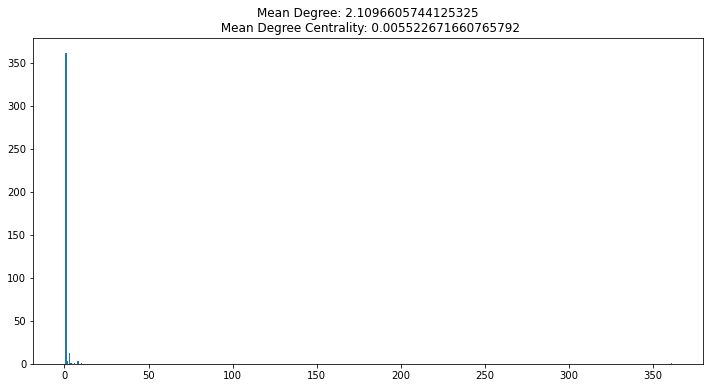

In [64]:
histdegree = pd.DataFrame(nx.degree_histogram(nx_graph))
degree = dict(nx.degree(nx_graph))

mean_degree = np.mean(list(degree.values()))
mean_degree_centrality = np.mean(list(nx.degree_centrality(nx_graph).values()))

fig, ax = plt.subplots(figsize=(12,6)) 
ax.bar(histdegree.index.values,histdegree[0])

plt.title("Mean Degree: {n1}\n Mean Degree Centrality: {n2}".format(n1=mean_degree,n2=mean_degree_centrality))
plt.show()

In [65]:
def find_blanknodes(g):
    blank_nodes = []
    BNode = rdflib.term.BNode
    for s, p, o in g:
        if isinstance(s, BNode):
            blank_nodes.append(s)
        if isinstance(o, BNode):
            blank_nodes.append(o)
    return blank_nodes 

print("Number of Blank Nodes: {n}".format(n=len(find_blanknodes(g))))

Number of Blank Nodes: 0


In [70]:

def clustering_louvain(nx_graph):
    
    mapping = pd.DataFrame(nx_graph.nodes())
    mapping['new_names'] = mapping[0].str.split("#",n=1,expand=False)
    mapping['label'] = 'NA'

    mapping_copy = mapping.copy()

    for ind, m in mapping_copy.iterrows():
        l = len(m['new_names'])
        names = m['new_names']
        mapping.loc[ind,'label'] = names[l-1]

    map_dict = dict(zip(mapping[0],mapping['label']))
    nx_graph_nl = nx.relabel_nodes(nx_graph, map_dict,copy=True)
    communities = nx_comm.louvain_communities(nx_graph_nl,resolution=1)
    print('Number of found communitites', len(communities),
    '\n Number of nodes in the graph',nx.number_of_nodes(nx_graph_nl))
    for i in range(len(communities)):
        print(f'{i}th community: \n',communities[i] )
        

    pos = nx.shell_layout(nx_graph_nl)
    nx.draw(nx_graph_nl, pos, edge_color='k',font_weight='light', 
            node_size= 100, width= 0.8)

    for com in communities:
        nx.draw_networkx_nodes(nx_graph_nl,
                            pos,
                            nodelist=com, 
                            #node_color=np.random.rand(3,),
                            node_color = range(len(com)),
                            label=True,
                            node_size=100)   
    return

clustering_louvain(nx_graph) 


AttributeError: module 'networkx.algorithms.community' has no attribute 'louvain_communities'